In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances;
#using ForwardDiff
#using ProgressMeter
#using BenchmarkTools;

In [245]:
#Hyperparameters
n = 20
N = n*4
σₐ = 0.02
σᵧ = 1.0 #Likelihood variance
k_range = 12
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

In [197]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

mₖ(k) = k*4 + 1;

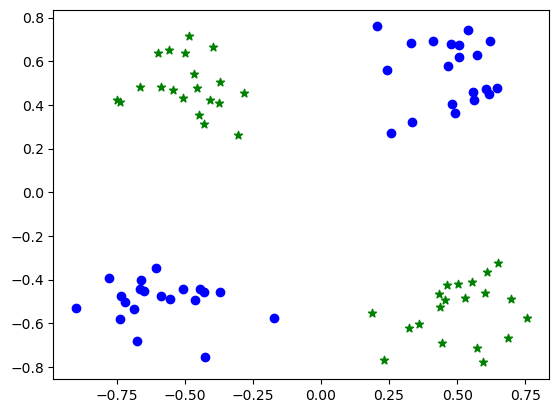

In [198]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [-0.5, -0.5]
    μ₂ = [-0.5, 0.5]
    μ₃ = [0.5, 0.5]
    μ₄ = [0.5, -0.5]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

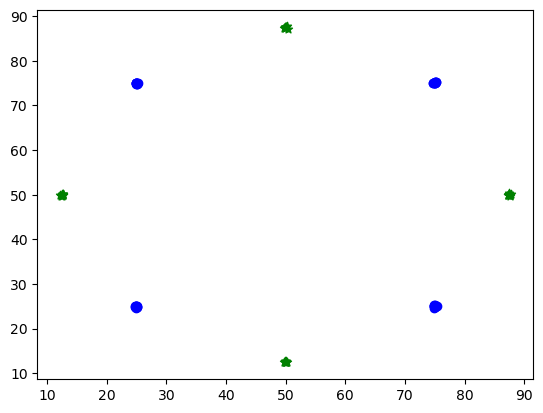

In [13]:
#Scale up - Fixed Separable Data - Multi-XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    a = 100
    μ₁ = [0.25, 0.25].*a
    μ₂ = [0.5, 0.125].*a
    μ₃ = [0.25, 0.75].*a
    μ₄ = [0.125, 0.50].*a
    μ₅ = [0.75, 0.75].*a
    μ₆ = [0.50, 0.875].*a
    μ₇ = [0.75, 0.25].*a
    μ₈ = [0.875, 0.50].*a
    μ = [μ₁, μ₂, μ₃, μ₄, μ₅, μ₆, μ₇, μ₈]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/8), 8, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

In [251]:
#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, relu),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    α = 0.0009 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    k ~ uniform_discrete(1,3) #Number of hidden nodes
    #k ~ k_count(1,0.5,1) #Shifted Negative Binomial
    #println(k)
    
    #Create individual weight and bias vectors
    m = mₖ(k)
    h = 2*k
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)

    
    #Return Network Scores for X
    scores = Flux.hardσ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k),200.0)
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))
    #y = zeros(length(scores))
    #for j=1:N
        #y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    #end

    return scores
    
end;

best_acc = 0.0
for i=1:10000
    predictions = classifier(data)
    preds = data_labeller(predictions)
    acc = sum([Int(classes[i]) == preds[i] for i=1:length(classes)])/length(classes)
    if acc > best_acc
        best_acc = acc
    end
    if acc % 0.25 != 0
        #plot_data(data_raw,preds)
        #println(acc)
    end
end
#plot_data(data_raw,preds)
print(best_acc)

0.9625

In [ ]:
z = classifier(data)
#v = data_labeller(z)
#print(z)
sum([data_labeller(z)[i] == classes[i] for i=1:length(classes)])

obs = choicemap()::ChoiceMap
(tracez,) = generate(classifier, (x_samp,), obs)
y_predictions = data_labeller(tracez[:y])

#y_predictions = [tracez[(:y,i)] for i=1:length(classes)]
sum([y_predictions[i] == Int(classes[i]) for i=1:length(classes)])

In [247]:
#Register Observed Data
y_samp = classes
x_samp = data
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp .- 1
#for i=1:length(classes)
    #obs_master[(:y,i)] = classes[i]
#end
obs = obs_master
scores = []
accs = []
ks = []
best_ks = []
ks = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_pred_labels = data_labeller(best_pred_y)
print(best_pred_labels)
best_acc = sum([classes[i] == best_pred_labels[i] for i=1:length(classes)])/length(classes)
#best_dist = euclidean(best_pred_labels, classes)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

0.5

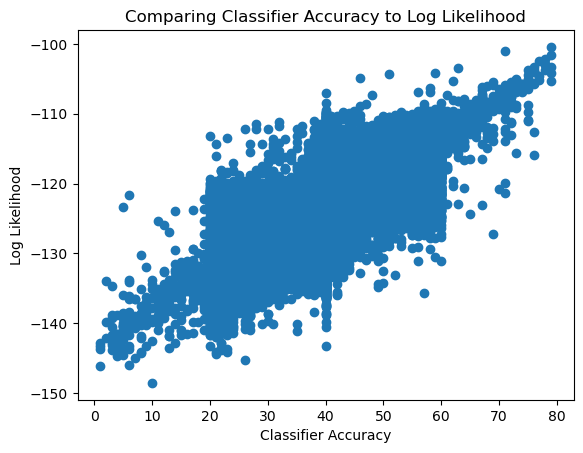

2

In [255]:
#Plot of Log Likelihood Scores
y_samp = classes
x_samp = data
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp .- 1
obs_master[:k] = 2
#for i=1:length(classes)
    #obs_master[(:y,i)] = classes[i]
#end
obs = obs_master
scores = []
accs = []
distances = []
ks = []
best_ks = []
ks = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_pred_labels = data_labeller(best_pred_y)
#println(best_pred_labels)
best_acc = sum([classes[i] == best_pred_labels[i] for i=1:length(classes)])
best_dist = euclidean(best_pred_y, classes)


function likelihood(best_trace, best_dist, best_score, best_k, best_acc)
    x_samp, y_samp = data, classes
    obs_master[:y] = y_samp .- 1
    #for i=1:length(classes)
        #obs_master[(:y,i)] = classes[i]
    #end
    obs = obs_master
    (trace,) = generate(classifier, (x_samp,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    #println(pred_labels)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    dist = euclidean(pred_y, classes)
    score = get_score(trace)
    #println(score)
    if score > best_score
        best_acc = acc
        best_score = score
        best_k = k
        best_trace = trace
        best_dist = dist
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(distances, dist)
    push!(ks, k)
    
    return(best_trace, best_dist, best_score, best_k, best_acc)
end

for i=1:200000
    best_trace, best_dist, best_score, best_k, best_acc = likelihood(best_trace, best_dist, best_score, best_k, best_acc)
    push!(best_ks, best_k)
end

scatter(accs,scores)
#plt.ylim(-50,0)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");
print(best_k)

In [230]:
#print(best_acc)
println(exp(-4))

0.01831563888873418


In [256]:
println(best_trace[:Wₕ])
println(best_trace[:Wₒ])
println(best_trace[:bₕ])
println(best_trace[:bₒ])
println(get_score(best_trace))
println(best_score)

[-3.426283240536362, 4.075098808058129, 3.508101352892328, -3.7804933212020884]
[2.879082765005354, 2.165092494128124]
[-1.4851500116308207, -1.7946082763717457]
[-0.7496355067643208]
-100.43818016394472
-100.43818016394472


In [219]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp .- 1
    obs_new[:Wₕ] = vcat(Wₕ,[0 for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[0 for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[0 for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp .- 1
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace
end;

In [220]:
traces = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=2, eps=uniform(0.04,0.06), check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
    end
    return trace
end
eps_list = []
function across_dimension(trace, iters, obs)
    
    new_trace = birth_or_death(trace)
    score_test = get_score(new_trace)
    
    test = true
    for i=1:iters
        eps = uniform(0.001,0.999)
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=2, eps=eps, observations=obs)
        #(new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=0.02, check=false, observations=obs)
        accepted && (test = false)
        accepted && (push!(eps_list,eps))
    end
    #test && println("Nothing accepted")
    
    test = true
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    score = exp(score2-score1)
    println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters

        if (i%100 == 0)
            #current_acc = (sum(acc[length(acc)-10:length(acc)])/11)
            #across_acc = (sum(acc_a)/length(acc_a))
            within_acc = (sum(acc_w)/length(acc_w))
            #println("Epoch $i Across Acceptance Prob: $across_acc")
            #println("Epoch $i Within Acceptance Prob: $within_acc")
        end
        
        if rand(Uniform(0,1)) > 0.99
            (trace, k) = across_dimension(trace, 100, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
runs = 20000
#starting_trace = best_trace
x_samp, y_samp = data, classes
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp .- 1
obs = obs_master;

(starting_trace,) = generate(classifier, (x_samp,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting k: 3
Old Trace: -106.36675602270765; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -106.36675602270765; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -106.36675602270765; Pre-HMC: -139.7561158871141; Post-HMC: -78.17163796589786
Old Trace: -80.24266765053429; Pre-HMC: -157.2540871991776; Post-HMC: -69.79177190117716
Old Trace: -69.2579957793403; Pre-HMC: -122.93938128991547; Post-HMC: -91.21101932833372
Old Trace: -68.6286279744616; Pre-HMC: -120.6107848018756; Post-HMC: -77.35567465630407
Old Trace: -68.65927020886849; Pre-HMC: -117.39218172421839; Post-HMC: -117.39218172421839
Old Trace: -68.61662255439488; Pre-HMC: -120.75228068755371; Post-HMC: -116.7514695372914
Old Trace: -69.65644671100488; Pre-HMC: -120.5163000260126; Post-HMC: -103.54507120137089
Old Trace: -72.79036513824899; Pre-HMC: -123.85157772232299; Post-HMC: -120.01586836857516
Old Trace: -71.63677177975701; Pre-HMC: -122.13764824541855; Post-HMC: -120.33365634419292
Old Trace: -71.35619441373252; Pre-

Old Trace: -29.72651478083739; Pre-HMC: -172.34352622503482; Post-HMC: -172.34352622503482
Old Trace: -29.887040248938966; Pre-HMC: -171.42326777343692; Post-HMC: -107.65461646065297
Old Trace: -30.122309517617968; Pre-HMC: -146.044975218981; Post-HMC: -93.63778898667181
Old Trace: -30.122309517617968; Pre-HMC: -145.45803683925263; Post-HMC: -74.4167519816431
Old Trace: -34.027097075130015; Pre-HMC: -147.58990959312064; Post-HMC: -77.2409253803649
Old Trace: -33.75139885844342; Pre-HMC: -167.5636836131028; Post-HMC: -70.60471703860243
Old Trace: -32.008411539685156; Pre-HMC: -169.09399029434854; Post-HMC: -70.54809500249672
Old Trace: -32.02005971690066; Pre-HMC: -169.11418179098752; Post-HMC: -69.13612811481399
Old Trace: -34.43589359922382; Pre-HMC: -159.40052311602022; Post-HMC: -72.29608204202664
Old Trace: -30.686499808137402; Pre-HMC: -169.47186065818923; Post-HMC: -86.21575093928844
Old Trace: -32.62341180651765; Pre-HMC: -121.4221599979368; Post-HMC: -70.36745953831736
Old Trac

In [164]:
eps_list

6337-element Array{Any,1}:
 0.2990778666921068
 0.30192595267899425
 0.3367932898585606
 0.15029148488100577
 0.20715131624706654
 0.1334345698601028
 0.25646502141825356
 0.05410629988053404
 0.26546608529327487
 0.17941389435065833
 0.274519777049543
 0.36735335382103446
 0.10098561181439349
 ⋮
 0.020332673335435703
 0.07969102300299089
 0.055583239388408305
 0.01823502632720872
 0.05869198663001242
 0.21163899916652273
 0.019915075469623223
 0.0020720552730851102
 0.04350927570363925
 0.022634205565181073
 0.06817925466959927
 0.033735994112009574

In [141]:
[obs[:y][i] == classes for i=1:length(classes)]
#print(classes)
print(obs[:y])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

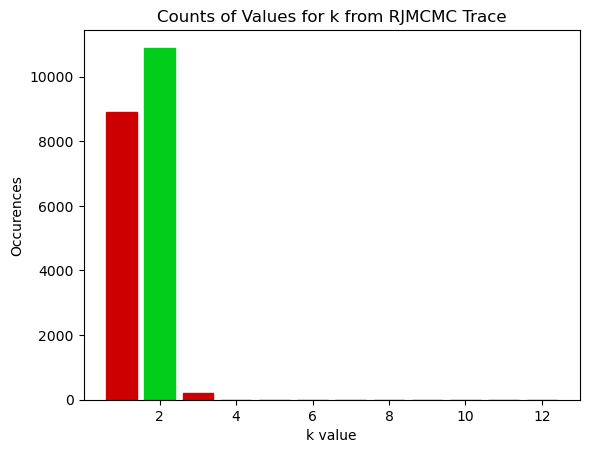

In [221]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

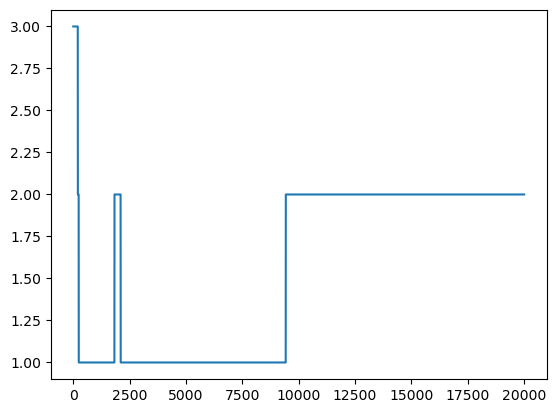

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe429846f10>

In [222]:
plot(ks)

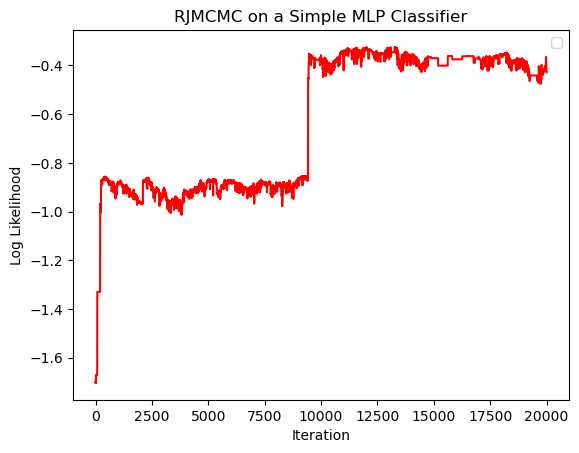

No handles with labels found to put in legend.


In [223]:
#hmc_traces_master = vcat(hmc_traces, hmc_traces2, hmc_traces3, hmc_traces4);
scores2 = zeros(length(traces))
for i=1:length(traces)
    trace = traces[i]
    obs = obs_master
    scores2[i] = get_score(trace)/length(classes)
end
plot(scores2, color="red")
#plot(scores2, color="green")
plt.title("RJMCMC on a Simple MLP Classifier")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
#plt.axvline(100,label="Burn-In: ~1000",color="red")
plt.legend();

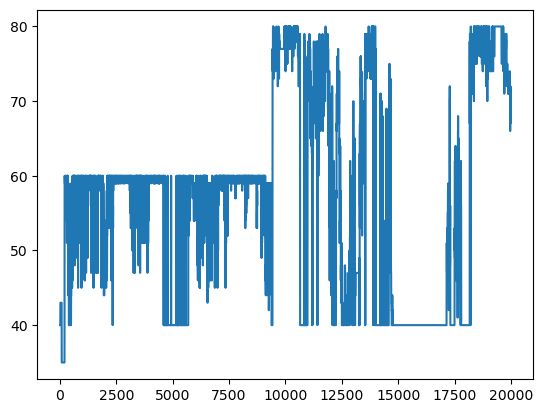

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe429c53890>

In [224]:
accs = []
for i=1:length(traces)
    trace = traces[i]
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    
    acc = acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    push!(accs,acc)
end
plot(accs)

In [ ]:
#Try Dynamic Plotting

anim = @animate for i ∈ 1:runs
    Plots.histogram(ks[1:i], bins=1:20)
end
gif(anim, "anim_fps15.gif", fps = 60)

In [ ]:
@gen function test()
    x ~ bernoulli(0.9)
    y ~ normal(x,1)
    return x
end

@gen function test2()
    x ~ bernoulli(0.1)
    y ~ normal(x,1)
    return x
end

obs_test = choicemap()::ChoiceMap
obs_test[:y] = 1



(z1, weight1) = generate(test, (), obs_test)
println(z1[:x])
#println(Distributions.logpdf(Normal(0,1),z1[:x]))
s1 = (get_score(z1))

(z2, weight2) = generate(test2, (), obs_test)
println(z2[:x])
#println(Distributions.logpdf(Normal(0,1),z1[:x]))
s2 = (get_score(z2))

print(exp(s1)/exp(s2))